In [ ]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering, BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import zipfile
import pandas as pd
from datasets import load_dataset

In [ ]:
!pip install bitsandbytes accelerate

In [ ]:
!pip install -U bitsandbytes

In [ ]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import files
# Upload zip file
print("Upload your VQA-RAD images zip file:")
uploaded_zip = files.upload()

# Upload CSV file
print("\nUpload your CSV file:")
uploaded_csv = files.upload()

# Get filenames
zip_filename = list(uploaded_zip.keys())[0]
csv_filename = list(uploaded_csv.keys())[0]

print(f"\nUploaded files:")
print(f"  Zip: {zip_filename}")
print(f"  CSV: {csv_filename}")

# Extract zip
extract_to = 'vqa_rad_images/'
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"\nImages extracted to: {extract_to}")
print("Extraction complete! ✅")

Upload your VQA-RAD images zip file:


Saving VQA_RAD Image.zip to VQA_RAD Image.zip

Upload your CSV file:


Saving vqa_rad_cleaned_train.csv to vqa_rad_cleaned_train.csv

Uploaded files:
  Zip: VQA_RAD Image.zip
  CSV: vqa_rad_cleaned_train.csv

Images extracted to: vqa_rad_images/
Extraction complete! ✅


In [ ]:
# Load CSV
import os
df = pd.read_csv(csv_filename)

# Check structure
print(f"CSV loaded: {len(df)} rows")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSample image names:")
print(df['image_name'].head())

# Check extracted folder structure
print(f"\nExtracted folder contents:")
for root, dirs, files in os.walk(extract_to):
    print(f"Folder: {root}")
    if files:
        print(f"Sample files: {files[:5]}")
    if dirs:
        print(f"Subfolders: {dirs}")
    break

CSV loaded: 2244 rows

Columns: ['qid', 'phrase_type', 'qid_linked_id', 'image_case_url', 'image_name', 'image_organ', 'evaluation', 'question', 'question_rephrase', 'question_relation', 'question_frame', 'question_type', 'answer', 'answer_type', 'image_path', 'split']

Sample image names:
0    synpic54610.jpg
1    synpic29265.jpg
2    synpic29265.jpg
3    synpic28602.jpg
4    synpic29265.jpg
Name: image_name, dtype: object

Extracted folder contents:
Folder: vqa_rad_images/
Sample files: ['synpic30273.jpg', 'synpic30215.jpg', 'synpic26248.jpg', 'synpic34017.jpg', 'synpic49862.jpg']


In [ ]:
# Create full image paths
df['full_image_path'] = df['image_name'].apply(lambda x: os.path.join(extract_to, x))

# Verify images exist
df['image_exists'] = df['full_image_path'].apply(os.path.exists)

print(f"Images found: {df['image_exists'].sum()} / {len(df)}")
print(f"Missing images: {(~df['image_exists']).sum()}")

# Keep only valid samples
df_valid = df[df['image_exists']].copy()

print(f"\nValid dataset size: {len(df_valid)}")
print(f"\nQuestion types:")
print(df_valid['question_type'].value_counts())

Images found: 2244 / 2244
Missing images: 0

Valid dataset size: 2244

Question types:
question_type
PRES            801
POS             314
ABN             201
OTHER           196
MODALITY        185
SIZE            170
PLANE           120
ATTRIB           88
ORGAN            59
COLOR            52
COUNT            24
ATTRIB, PRES     10
POS, PRES        10
ABN, POS          5
COLOR, PRES       3
PRES, SIZE        2
COLOR, SIZE       2
ATTRIB, SIZE      1
ABN, PRES         1
Name: count, dtype: int64


In [ ]:
# Keep only essential columns
columns_to_keep = [
    'image_name',
    'question',
    'answer',
    'question_type',
    'answer_type',
    'image_organ',
    'split',
    'full_image_path',
    'image_exists'
]

df_valid = df_valid[columns_to_keep].copy()

print(f"Cleaned dataset columns: {df_valid.columns.tolist()}")
print(f"Dataset size: {len(df_valid)}")
print(f"\nFirst few rows:")
print(df_valid.head())

Cleaned dataset columns: ['image_name', 'question', 'answer', 'question_type', 'answer_type', 'image_organ', 'split', 'full_image_path', 'image_exists']
Dataset size: 2244

First few rows:
        image_name                                      question      answer  \
0  synpic54610.jpg            are regions of the brain infarcted         yes   
1  synpic29265.jpg                are the lungs normal appearing          no   
2  synpic29265.jpg           is there evidence of a pneumothorax          no   
3  synpic28602.jpg  what type of imaging does this not represent  ultrasound   
4  synpic29265.jpg                    is this a mri of the chest          no   

  question_type answer_type image_organ  split  \
0          PRES      CLOSED        HEAD  Train   
1           ABN      CLOSED       CHEST  Train   
2          PRES      CLOSED       CHEST  Train   
3      MODALITY        OPEN       CHEST  Train   
4      MODALITY      CLOSED       CHEST  Train   

                  full_image_

In [ ]:
from sklearn.model_selection import train_test_split

# Use existing split column
train_df = df_valid[df_valid['split'] == 'Train'].reset_index(drop=True)
test_df = df_valid[df_valid['split'] == 'Test'].reset_index(drop=True)

print(f"Original splits from CSV:")
print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

# Create validation split from train (15%)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.15,
    random_state=42,

)

print(f"\nFinal splits:")
print(f"Train: {len(train_df)}")
print(f"Val: {len(val_df)}")
print(f"Test: {len(test_df)}")

Original splits from CSV:
Train: 1793
Test: 451

Final splits:
Train: 1524
Val: 269
Test: 451


In [ ]:
from torchvision import transforms

# Define image preprocessing pipeline
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
from transformers import AutoTokenizer

# Load Qwen3-4B tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "Qwen/Qwen3-4B-Instruct-2507",
    trust_remote_code=True
)

# Add special image token
special_tokens = {"additional_special_tokens": ["<image>"]}
tokenizer.add_special_tokens(special_tokens)

# Verify
print(f"Vocabulary size: {len(tokenizer)}")
print(f"Image token ID: {tokenizer.convert_tokens_to_ids('<image>')}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Vocabulary size: 151670
Image token ID: 151669


In [ ]:
from torch.utils.data import Dataset

class VQADataset(Dataset):
    def __init__(self, df, tokenizer, image_transform, max_length=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image from path
        image = Image.open(row['full_image_path']).convert('RGB')
        image = self.image_transform(image)

        # Get question and answer
        question = row['question']
        answer = row['answer']

        # Create full text: "<image>\nQuestion: {question}\nAnswer: {answer}"
        full_text = f"<image>\nQuestion: {question}\nAnswer: {answer}"

        # Tokenize
        tokens = self.tokenizer(
            full_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'image': image,
            'input_ids': tokens['input_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'labels': tokens['input_ids'].squeeze(0),
            'answer_text': answer,
            'question_type': row['question_type'],
            'answer_type': row['answer_type'],
            'image_organ': row['image_organ']
        }
batch_size = 4
# Create VQADataset instances
train_dataset = VQADataset(train_df, tokenizer, image_transform)
val_dataset = VQADataset(val_df, tokenizer, image_transform)
test_dataset = VQADataset(test_df, tokenizer, image_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Datasets created:")
print(f"Train: {len(train_dataset)} samples")
print(f"Val: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

Datasets created:
Train: 1524 samples
Val: 269 samples
Test: 451 samples


In [ ]:
# Install if needed
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00


In [ ]:


import open_clip

model, preprocess = open_clip.create_model_from_pretrained(
    'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
)
vision_encoder = model.visual  # Extract vision encoder only

open_clip_config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

open_clip_pytorch_model.bin:   0%|          | 0.00/784M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [ ]:
# Freeze all parameters
for param in vision_encoder.parameters():
    param.requires_grad = False

# Move to device
vision_encoder = vision_encoder.to(device)
vision_encoder.eval()

# Verify
print(f"Vision encoder loaded")
print(f"Parameters frozen: {not next(vision_encoder.parameters()).requires_grad}")
print(f"Device: {next(vision_encoder.parameters()).device}")

Vision encoder loaded
Parameters frozen: True
Device: cuda:0


In [ ]:
# Check for the correct attribute
if hasattr(vision_encoder, 'embed_dim'):
    print(f"Output dimension: {vision_encoder.embed_dim}")
elif hasattr(vision_encoder, 'num_features'):
    print(f"Output dimension: {vision_encoder.num_features}")
else:
    # Test with dummy input
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    with torch.no_grad():
        output = vision_encoder(dummy_input)
    print(f"Output dimension: {output.shape[-1]}")

Output dimension: 512


In [ ]:
# Get a sample from train dataset
row_idx = 0 # Example row index
sample = train_df.iloc[row_idx]
image = Image.open(sample['full_image_path']).convert('RGB') # Load image using full_image_path

# Apply preprocessing
image_tensor = image_transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Extract features
with torch.no_grad():
    features = vision_encoder(image_tensor)

print(f"Input image shape: {image_tensor.shape}")
print(f"Output features shape: {features.shape}")
print(f"Feature sample (first 10 values): {features[0, :10]}")

# Visualize the image
plt.imshow(image)
plt.title(f"Q: {sample['question']}\nA: {sample['answer']}")
plt.axis('off')
plt.show()

In [ ]:
import torch.nn as nn

class Projector(nn.Module):
    def __init__(self, vision_dim=512, llm_dim=2560):
        super().__init__()
        # Wrap everything in nn.Sequential so PyTorch registers the parameters
        self.proj = nn.Sequential(
            # Stage 1: 512 -> 1024
            nn.Linear(vision_dim, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),

            # Stage 2: 1024 -> 2048
            nn.Linear(1024, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Dropout(0.1),

            # Stage 3: 2048 -> 2560 (LLM Hidden Size)
            nn.Linear(2048, llm_dim)
        )

    def forward(self, x):
        # Now self.proj is defined and contains all layers
        return self.proj(x)

# Create projector
# Ensure 'device' is defined (e.g., device = "cuda" if torch.cuda.is_available() else "cpu")
projector = Projector(vision_dim=512, llm_dim=2560).to(device)

print(f"Projector created")
print(f"Trainable parameters: {sum(p.numel() for p in projector.parameters()):,}")

Projector created
Trainable parameters: 7,876,096


In [ ]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model

# 8-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True  # Just this parameter is needed for 8-bit
)

# Load LLM
llm = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen3-4B-Instruct-2507",
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# LoRA config
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA
llm = get_peft_model(llm, lora_config)

print("LLM loaded with LoRA")
llm.print_trainable_parameters()

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

LLM loaded with LoRA
trainable params: 5,898,240 || all params: 4,028,366,336 || trainable%: 0.1464


In [ ]:
# Check the native context window
print(f"Max Context Window: {llm.config.max_position_embeddings} tokens")

Max Context Window: 262144 tokens


In [ ]:
class VLMModel(nn.Module):
    def __init__(self, vision_encoder, projector, llm, tokenizer):
        super().__init__()
        self.vision_encoder = vision_encoder
        self.projector = projector
        self.llm = llm
        self.tokenizer = tokenizer
        self.image_token_id = tokenizer.convert_tokens_to_ids('<image>')

    def forward(self, images, input_ids, attention_mask, labels=None):
        # Extract visual features
        with torch.no_grad():
            visual_features = self.vision_encoder(images)  # [batch, 512]

        # Project to LLM embedding space
        visual_embeds = self.projector(visual_features)  # [batch, 1536]
        visual_embeds = visual_embeds.unsqueeze(1)  # [batch, 1, 1536]

        # Get text embeddings
        text_embeds = self.llm.get_input_embeddings()(input_ids)  # [batch, seq_len, 1536]

        # Find <image> token positions and replace with visual embeddings
        batch_size = input_ids.shape[0]
        for i in range(batch_size):
            image_pos = (input_ids[i] == self.image_token_id).nonzero(as_tuple=True)[0]
            if len(image_pos) > 0:
                text_embeds[i, image_pos[0]] = visual_embeds[i, 0]

        # Forward through LLM - don't pass labels, compute loss manually
        outputs = self.llm(
            inputs_embeds=text_embeds,
            attention_mask=attention_mask
        )

        # Manually compute loss if labels provided
        loss = None
        if labels is not None:
            logits = outputs.logits
            # Shift for causal LM: predict next token
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()

            loss_fct = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

            # Create outputs with loss
            from transformers.modeling_outputs import CausalLMOutputWithPast
            outputs = CausalLMOutputWithPast(loss=loss, logits=logits)

        return outputs

# Recreate VLM with fixed forward
vlm_model = VLMModel(vision_encoder, projector, llm, tokenizer)
print("VLM model recreated with fix")

VLM model recreated with fix


In [ ]:
import copy
from peft import get_peft_model_state_dict, set_peft_model_state_dict

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        '''Saves ONLY the trainable parts of the model.'''
        if self.verbose:
            print(f'Validation loss decreased. Saving best model state...')

        # 1. Capture Projector state
        projector_state = copy.deepcopy(model.projector.state_dict())

        # 2. Capture ONLY the LoRA adapter weights (NOT the whole LLM)
        lora_state = get_peft_model_state_dict(model.llm)

        self.best_state = {
            'projector': projector_state,
            'llm_lora': lora_state
        }

In [ ]:
from torch.optim import AdamW

# Get trainable parameters (projector + LoRA)
trainable_params = [
    {'params': projector.parameters(), 'lr': 1e-4},
    {'params': llm.parameters(), 'lr': 5e-5}
]

# Create optimizer
optimizer = AdamW(trainable_params, weight_decay=0.01)

# Training config
# Updated Training Config
num_epochs = 5
patience = 3  # Stop if no improvement after 3 epochs
early_stopping = EarlyStopping(patience=patience, verbose=True)
gradient_accumulation_steps = 4  # Effective batch = 4 * 4 = 16

print(f"Optimizer created")
print(f"Epochs: {num_epochs}")
print(f"Effective batch size: {batch_size * gradient_accumulation_steps}")

Optimizer created
Epochs: 5
Effective batch size: 16


In [ ]:
from tqdm import tqdm

def train_epoch(model, train_loader, optimizer, device, gradient_accumulation_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    progress_bar = tqdm(train_loader, desc="Training")

    for step, batch in enumerate(progress_bar):
        # Move batch to device
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(images, input_ids, attention_mask, labels)
        loss = outputs.loss / gradient_accumulation_steps

        # Backward pass
        loss.backward()

        # Update weights every gradient_accumulation_steps
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps
        progress_bar.set_postfix({'loss': f'{loss.item() * gradient_accumulation_steps:.4f}'})

    return total_loss / len(train_loader)

print("Training function ready")

Training function ready


In [ ]:
def validate(model, val_loader, device):
    model.eval()
    total_loss = 0

    progress_bar = tqdm(val_loader, desc="Validation")

    with torch.no_grad():
        for batch in progress_bar:
            # Move batch to device
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask, labels)
            loss = outputs.loss

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(val_loader)

print("Validation function ready")

Validation function ready


In [ ]:
# Training history
train_losses = []
val_losses = []

print("Starting training with Early Stopping...")

for epoch in range(num_epochs):
    print(f"\n{'='*50}\nEpoch {epoch + 1}/{num_epochs}\n{'='*50}")

    # 1. Train [cite: 4990-4992]
    train_loss = train_epoch(vlm_model, train_loader, optimizer, device, gradient_accumulation_steps)
    train_losses.append(train_loss)

    # 2. Validate [cite: 5000-5003]
    val_loss = validate(vlm_model, val_loader, device)
    val_losses.append(val_loss)

    print(f"\nEpoch {epoch + 1} Summary: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # 3. Early Stopping Check
    early_stopping(val_loss, vlm_model)

    if early_stopping.early_stop:
        print("Early stopping triggered. Training halted.")
        break

# 4. Load the best model state found during training
if early_stopping.best_state:
    print("Loading best model parameters for final evaluation...")

    # Load Projector
    vlm_model.projector.load_state_dict(early_stopping.best_state['projector'])

    # Load LoRA Adapters specifically
    set_peft_model_state_dict(vlm_model.llm, early_stopping.best_state['llm_lora'])

    print("Best state restored successfully.")

print("\nTraining complete!")

Starting training with Early Stopping...

Epoch 1/5


Validation: 100%|██████████| 68/68 [00:31<00:00,  2.16it/s, loss=1.2266]



Epoch 1 Summary: Train Loss: 1.3226, Val Loss: 1.3759
Validation loss decreased. Saving best model state...

Epoch 2/5


Validation: 100%|██████████| 68/68 [00:31<00:00,  2.14it/s, loss=1.1846]



Epoch 2 Summary: Train Loss: 1.2558, Val Loss: 1.3509
Validation loss decreased. Saving best model state...

Epoch 3/5


Validation: 100%|██████████| 68/68 [00:31<00:00,  2.14it/s, loss=1.1348]



Epoch 3 Summary: Train Loss: 1.2041, Val Loss: 1.3400
Validation loss decreased. Saving best model state...

Epoch 4/5


Validation: 100%|██████████| 68/68 [00:31<00:00,  2.14it/s, loss=1.1611]



Epoch 4 Summary: Train Loss: 1.1498, Val Loss: 1.3230
Validation loss decreased. Saving best model state...

Epoch 5/5


Validation: 100%|██████████| 68/68 [00:32<00:00,  2.10it/s, loss=1.0225]


Epoch 5 Summary: Train Loss: 1.0914, Val Loss: 1.3275
EarlyStopping counter: 1 out of 3
Loading best model parameters for final evaluation...
Best state restored successfully.

Training complete!


In [ ]:
def generate_answer(model, image, question, tokenizer, device, max_length=15):
    model.eval()

    image_tensor = image_transform(image).unsqueeze(0).to(device)
    prompt = f"<image>\nQuestion: {question}\nAnswer:"

    inputs = tokenizer(prompt, return_tensors='pt', padding=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        visual_features = model.vision_encoder(image_tensor)
        visual_embeds = model.projector(visual_features).unsqueeze(1)

        text_embeds = model.llm.get_input_embeddings()(input_ids)
        image_pos = (input_ids[0] == model.image_token_id).nonzero(as_tuple=True)[0]
        if len(image_pos) > 0:
            text_embeds[0, image_pos[0]] = visual_embeds[0, 0]

        outputs = model.llm.generate(
            inputs_embeds=text_embeds,
            attention_mask=attention_mask,
            max_new_tokens=10,  # ← Changed from 50 to 10
            min_new_tokens=1,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False,  # Greedy decoding
            temperature=1.0,
            repetition_penalty=1.2  # Prevent loops
        )

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = answer.split("Answer:")[-1].strip()

    # Truncate at first period or newline for closed-ended
    answer = answer.split('.')[0].split('\n')[0].strip()

    return answer

In [ ]:
# Get a test sample
original_test_idx = 15 # Using the first sample from the test_dataset for consistency

# Get the full row from the original test_df to access the path
# This ensures we get the original PIL Image for generate_answer and display
row_from_test_df = test_df.iloc[original_test_idx]
test_image_pil = Image.open(row_from_test_df['full_image_path']).convert('RGB')

# Extract question and ground truth from the dataframe row
test_question = row_from_test_df['question']
ground_truth = row_from_test_df['answer']

# Generate prediction using the PIL image
predicted_answer = generate_answer(
    vlm_model,
    test_image_pil, # Pass the PIL image here
    test_question,
    tokenizer,
    device
)

# Display results using the PIL image
plt.imshow(test_image_pil)
plt.axis('off')
plt.title(f"Question: {test_question}", fontsize=10)
plt.show()

print(f"Ground Truth: {ground_truth}")
print(f"Predicted: {predicted_answer}")

In [ ]:
# Get a test sample
original_test_idx = 5 # Using the first sample from the test_dataset for consistency

# Get the full row from the original test_df to access the path
# This ensures we get the original PIL Image for generate_answer and display
row_from_test_df = test_df.iloc[original_test_idx]
test_image_pil = Image.open(row_from_test_df['full_image_path']).convert('RGB')

# Extract question and ground truth from the dataframe row
test_question = row_from_test_df['question']
ground_truth = row_from_test_df['answer']

# Generate prediction using the PIL image
predicted_answer = generate_answer(
    vlm_model,
    test_image_pil, # Pass the PIL image here
    test_question,
    tokenizer,
    device
)

# Display results using the PIL image
plt.imshow(test_image_pil)
plt.axis('off')
plt.title(f"Question: {test_question}", fontsize=10)
plt.show()

print(f"Ground Truth: {ground_truth}")
print(f"Predicted: {predicted_answer}")

In [ ]:
# Get a test sample
original_test_idx = 25 # Using the first sample from the test_dataset for consistency

# Get the full row from the original test_df to access the path
# This ensures we get the original PIL Image for generate_answer and display
row_from_test_df = test_df.iloc[original_test_idx]
test_image_pil = Image.open(row_from_test_df['full_image_path']).convert('RGB')

# Extract question and ground truth from the dataframe row
test_question = row_from_test_df['question']
ground_truth = row_from_test_df['answer']

# Generate prediction using the PIL image
predicted_answer = generate_answer(
    vlm_model,
    test_image_pil, # Pass the PIL image here
    test_question,
    tokenizer,
    device
)

# Display results using the PIL image
plt.imshow(test_image_pil)
plt.axis('off')
plt.title(f"Question: {test_question}", fontsize=10)
plt.show()

print(f"Ground Truth: {ground_truth}")
print(f"Predicted: {predicted_answer}")

In [ ]:
# Get a test sample
original_test_idx = 35 # Using the first sample from the test_dataset for consistency

# Get the full row from the original test_df to access the path
# This ensures we get the original PIL Image for generate_answer and display
row_from_test_df = test_df.iloc[original_test_idx]
test_image_pil = Image.open(row_from_test_df['full_image_path']).convert('RGB')

# Extract question and ground truth from the dataframe row
test_question = row_from_test_df['question']
ground_truth = row_from_test_df['answer']

# Generate prediction using the PIL image
predicted_answer = generate_answer(
    vlm_model,
    test_image_pil, # Pass the PIL image here
    test_question,
    tokenizer,
    device
)

# Display results using the PIL image
plt.imshow(test_image_pil)
plt.axis('off')
plt.title(f"Question: {test_question}", fontsize=10)
plt.show()

print(f"Ground Truth: {ground_truth}")
print(f"Predicted: {predicted_answer}")

Computing Test Loss: 100%|██████████| 113/113 [00:53<00:00,  2.12it/s]



Final Loss Comparison:
Final Train Loss: 1.0914
Final Val Loss: 1.3275
Test Loss: 1.3199


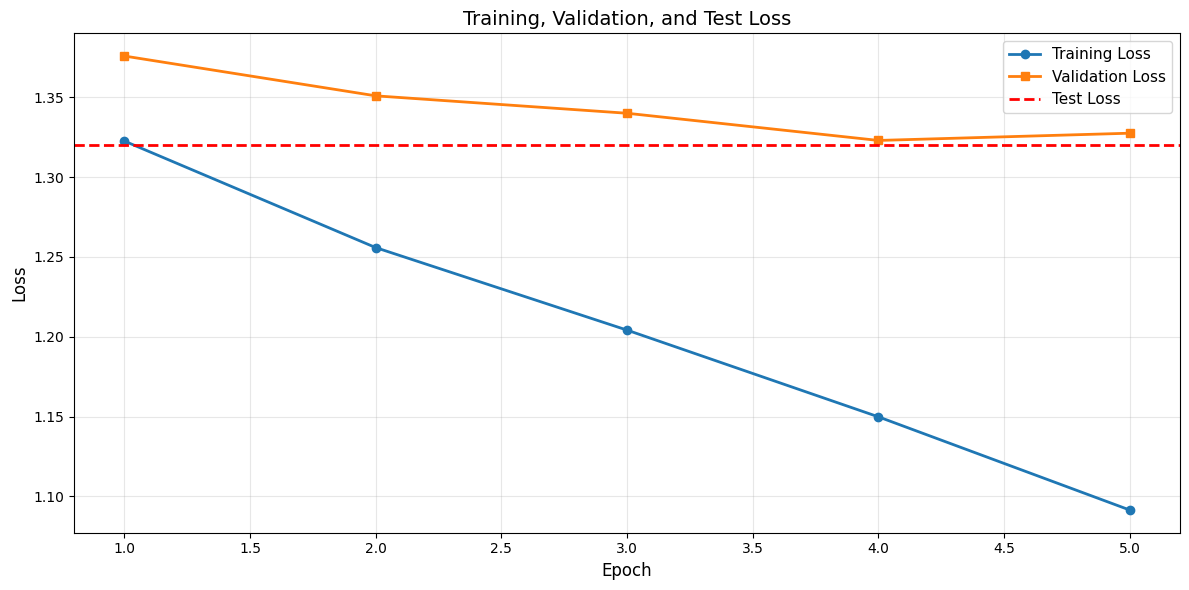

In [ ]:
# After training completes, calculate test loss
def compute_test_loss(model, test_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Computing Test Loss"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(images, input_ids, attention_mask, labels)
            loss = outputs.loss
            total_loss += loss.item()

    return total_loss / len(test_loader)

# Calculate test loss
test_loss = compute_test_loss(vlm_model, test_loader, device)

print(f"\nFinal Loss Comparison:")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot all three
plt.figure(figsize=(12, 6))

# Training and validation over epochs
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss', linewidth=2)
plt.plot(epochs, val_losses, marker='s', label='Validation Loss', linewidth=2)

# Test loss as horizontal line (computed once)
plt.axhline(y=test_loss, color='red', linestyle='--', linewidth=2, label='Test Loss')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training, Validation, and Test Loss', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c943f70f5f9186f1d4a96b3cb0c160064b5b7cedaeb351af022a4988b1fdd494
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import numpy as np
from tqdm import tqdm
from PIL import Image

In [ ]:
import re


def clean_closed_answer(pred):
    """
    Extract yes/no from potentially verbose answers.
    Handles cases like "Yes, there is...", "No signs of...", etc.
    """
    pred = pred.lower().strip()

    # Match "yes" at start of string (with word boundary)
    if re.match(r'^yes\b', pred):
        return "yes"

    # Match "no" at start of string (with word boundary)
    if re.match(r'^no\b', pred):
        return "no"

    # If no clear yes/no pattern, return first word as fallback
    return pred.split()[0] if pred.split() else ""


def evaluate_comprehensive(model, test_df, tokenizer, device):
    """
    Single-pass evaluation with all metrics:
    - Overall accuracy by question type
    - Closed-ended: Accuracy (with regex cleaning)
    - Open-ended: Exact Match, BLEU-4, ROUGE-L
    """
    results = {
        'closed': {'predictions': [], 'ground_truths': []},
        'open': {'predictions': [], 'ground_truths': []},
        'all': []  # For question type breakdown
    }

    # Generate all predictions (SINGLE PASS)
    for idx in tqdm(range(len(test_df)), desc="Evaluating"):
        row = test_df.iloc[idx]

        # Load image and generate prediction
        image = Image.open(row['full_image_path']).convert('RGB')
        pred = generate_answer(model, image, row['question'], tokenizer, device)

        pred_clean = pred.lower().strip()
        gt_clean = row['answer'].lower().strip()

        # For closed-ended, use regex cleaning
        if row['answer_type'] == 'CLOSED':
            pred_for_comparison = clean_closed_answer(pred_clean)
            gt_for_comparison = clean_closed_answer(gt_clean)
        else:
            # For open-ended, keep first word for overall accuracy
            pred_for_comparison = pred_clean.split()[0] if pred_clean.split() else ""
            gt_for_comparison = gt_clean.split()[0] if gt_clean.split() else ""

        # Store for question type analysis
        results['all'].append({
            'prediction': pred_for_comparison,
            'prediction_full': pred_clean,  # Keep full for open-ended metrics
            'ground_truth': gt_for_comparison,
            'ground_truth_full': gt_clean,
            'question_type': row['question_type'],
            'answer_type': row['answer_type'],
            'organ': row['image_organ']
        })

        # Separate by answer type
        if row['answer_type'] == 'CLOSED':
            results['closed']['predictions'].append(pred_clean)
            results['closed']['ground_truths'].append(gt_clean)
        else:  # OPEN
            results['open']['predictions'].append(pred_clean)
            results['open']['ground_truths'].append(gt_clean)

    # Convert to DataFrame for analysis
    df_results = pd.DataFrame(results['all'])

    # ===== OVERALL ACCURACY =====
    overall_correct = (df_results['prediction'] == df_results['ground_truth']).sum()
    overall_acc = overall_correct / len(df_results) * 100

    # ===== CLOSED-ENDED ACCURACY (WITH REGEX CLEANING) =====
    closed_correct = 0
    for pred, gt in zip(results['closed']['predictions'], results['closed']['ground_truths']):
        pred_cleaned = clean_closed_answer(pred)
        gt_cleaned = clean_closed_answer(gt)

        if pred_cleaned == gt_cleaned:
            closed_correct += 1

    closed_acc = (closed_correct / len(results['closed']['predictions']) * 100) if results['closed']['predictions'] else 0

    # ===== OPEN-ENDED METRICS =====
    open_exact = []
    open_bleu4 = []
    open_rouge_l = []

    rouge_scorer_obj = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    smoothing = SmoothingFunction()

    for pred, gt in zip(results['open']['predictions'], results['open']['ground_truths']):
        # Exact Match (using full predictions)
        exact = 1.0 if pred == gt else 0.0
        open_exact.append(exact)

        # Tokenize
        pred_tokens = pred.split()
        gt_tokens = gt.split()

        # BLEU-4
        if len(pred_tokens) > 0 and len(gt_tokens) > 0:
            bleu4 = sentence_bleu(
                [gt_tokens],
                pred_tokens,
                weights=(0.25, 0.25, 0.25, 0.25),
                smoothing_function=smoothing.method1
            )
        else:
            bleu4 = 0.0
        open_bleu4.append(bleu4)

        # ROUGE-L
        rouge_scores = rouge_scorer_obj.score(gt, pred)
        open_rouge_l.append(rouge_scores['rougeL'].fmeasure)

    # Calculate averages
    open_exact_avg = np.mean(open_exact) * 100 if open_exact else 0
    open_bleu4_avg = np.mean(open_bleu4) * 100 if open_bleu4 else 0
    open_rouge_l_avg = np.mean(open_rouge_l) * 100 if open_rouge_l else 0

    # ===== PRINT RESULTS =====
    print("\n" + "="*70)
    print(" " * 20 + "EVALUATION RESULTS (WITH REGEX CLEANING)")
    print("="*70)

    print(f"\n📊 OVERALL PERFORMANCE:")
    print(f"   Accuracy: {overall_acc:.2f}% ({overall_correct}/{len(df_results)})")

    print(f"\n📊 BY ANSWER TYPE:")
    print(f"   Closed-ended ({len(results['closed']['predictions'])} samples):")
    print(f"      Accuracy: {closed_acc:.2f}% ({closed_correct}/{len(results['closed']['predictions'])})")
    print(f"      ✨ Now using regex to extract yes/no from verbose answers!")

    print(f"\n   Open-ended ({len(results['open']['predictions'])} samples):")
    print(f"      Exact Match:  {open_exact_avg:.2f}%")
    print(f"      BLEU-4:       {open_bleu4_avg:.2f}%")
    print(f"      ROUGE-L:      {open_rouge_l_avg:.2f}%")

    print(f"\n📊 BY QUESTION TYPE:")
    for qtype in df_results['question_type'].value_counts().index[:10]:
        mask = df_results['question_type'] == qtype
        correct = (df_results[mask]['prediction'] == df_results[mask]['ground_truth']).sum()
        total = mask.sum()
        acc = correct / total * 100
        print(f"   {qtype:15s}: {acc:5.2f}% ({correct}/{total})")

    print("\n" + "="*70)

    return {
        'overall_acc': overall_acc,
        'closed_acc': closed_acc,
        'open_exact': open_exact_avg,
        'open_bleu4': open_bleu4_avg,
        'open_rouge_l': open_rouge_l_avg,
        'df_results': df_results,
        'results': results
    }




In [ ]:
# Run complete evaluation with improved regex cleaning
metrics = evaluate_comprehensive(vlm_model, test_df, tokenizer, device)

Evaluating: 100%|██████████| 451/451 [18:27<00:00,  2.45s/it]


                    EVALUATION RESULTS (WITH REGEX CLEANING)

📊 OVERALL PERFORMANCE:
   Accuracy: 48.12% (217/451)

📊 BY ANSWER TYPE:
   Closed-ended (272 samples):
      Accuracy: 58.82% (160/272)
      ✨ Now using regex to extract yes/no from verbose answers!

   Open-ended (179 samples):
      Exact Match:  3.35%
      BLEU-4:       4.46%
      ROUGE-L:      22.40%

📊 BY QUESTION TYPE:
   PRES           : 47.85% (78/163)
   POS            : 44.83% (26/58)
   ABN            : 46.43% (26/56)
   SIZE           : 46.67% (21/45)
   MODALITY       : 45.45% (15/33)
   OTHER          : 38.46% (10/26)
   PLANE          : 76.92% (20/26)
   ATTRIB         : 41.18% (7/17)
   ORGAN          : 60.00% (6/10)
   COUNT          : 50.00% (3/6)

